**Dataset**
labeled datasset collected from twitter

**Objective**
classify tweets containing hate speech from other tweets. <br>
0 -> no hate speech <br>
1 -> contains hate speech <br>

**Evaluation metric**
macro f1 score

<span style="color:red">__Approach__</span>
1. Scan hyperparamter space for getting best HP with different variations of model
2. Try all the methods RNN, LSTM, GRU on the model with best HP configurations and select best method
3. Test the best method & HP with different embeddings and get our final model with highest performance

### Import Libraries

In [4]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import re, html, emoji
import matplotlib.pyplot as plt
import gensim.downloader as api
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from scipy.sparse import issparse
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, SimpleRNN, LSTM, GRU, Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.models import Model
from sklearn.pipeline import Pipeline
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from sklearn.metrics import f1_score, classification_report

### Load Dataset

In [5]:
data = pd.read_csv("Hate Speech.tsv", sep='\t', index_col= 'id')
data

,label,tweet
id,,
1,0,@user when a father is dysfunctional and is so...
2,0,@user @user thanks for #lyft credit i can't us...
3,0,bihday your majesty
4,0,#model i love u take with u all the time in ...
5,0,factsguide: society now #motivation
...,...,...
31958,0,ate @user isz that youuu?ðððððð...
31959,0,to see nina turner on the airwaves trying to w...
31960,0,listening to sad songs on a monday morning otw...


### Data splitting

In [6]:
train_size = int(0.7 * len(data))
test_size = val_size = int(0.15 * len(data))
print(f"train_size: {train_size}\ntest_size: {test_size}\nval_size: {val_size}")

train_size: 22074
test_size: 4730
val_size: 4730


In [7]:
train = data[:train_size]
val = data[train_size:train_size+val_size]
test = data[train_size+val_size:]

print(f"train class distribution\n{train['label'].value_counts()}")
print(f"class distribution {train['label'].value_counts()[1]/train['label'].value_counts()[0]}\n")
print(f"val class distribution\n{val['label'].value_counts()}")
print(f"class distribution {val['label'].value_counts()[1]/val['label'].value_counts()[0]}\n")
print(f"test class distribution\n{test['label'].value_counts()}")
print(f"class distribution {test['label'].value_counts()[1]/test['label'].value_counts()[0]}")

train class distribution
label
0    20531
1     1543
Name: count, dtype: int64
class distribution 0.07515464419658079

val class distribution
label
0    4395
1     335
Name: count, dtype: int64
class distribution 0.07622298065984073

test class distribution
label
0    4396
1     335
Name: count, dtype: int64
class distribution 0.07620564149226569


### Preprocessing

In [8]:
class textCleaner(BaseEstimator, TransformerMixin):
    def __init__(self, text_column='tweet'):
        self.text_column = text_column

    def fit(self, X, y= None):
        return self
    
    def transform(self, X):
        X = X.copy()
        X[self.text_column] = X[self.text_column].apply(self.clean_text)
        return X
    
    def clean_text(self, text, encode_emoji=True):
        text = html.unescape(text)
        text = re.sub(r'@\w+', '', text)
        text = re.sub(r'#(\w+)', lambda m: re.sub(r'(?<=[a-z])(?=[A-Z])', ' ', m.group(1)), text)
        text = re.sub(r'http\S+|www\S+', '', text)

        if encode_emoji:
            text = emoji.demojize(text)
            text = re.sub(r':([a-zA-Z_]+):', r'\1', text)

        text = text.lower()
        text = re.sub(r'\d+', '<NUM>', text)
        text = re.sub(r'[^\x00-\x7F]+', '', text)
        text = re.sub(r'[^\w\s<>]', '', text)
        text = re.sub(r'_+', ' ', text).strip()
        text = re.sub(r'\s+', ' ', text).strip()
        return text

In [9]:
class Vectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, method="SEQUENCE_RANDOM", text_column="tweet", max_len=100, num_words=10000, vector_size=300):
        self.method = method.upper()
        self.text_column = text_column
        self.max_len = max_len
        self.num_words = num_words
        self.vector_size = vector_size

    def fit(self, X, y=None):
        texts = X[self.text_column].values

        self.tokenizer_ = Tokenizer(num_words=self.num_words, oov_token="<OOV>")
        self.tokenizer_.fit_on_texts(texts)

        if self.method == "SEQUENCE_W2V":
            self.embeddings_ = api.load("word2vec-google-news-300")
            self.embedding_matrix_ = self._build_embedding_matrix()

        elif self.method == "SEQUENCE_GLOVE":
            self.embeddings_ = api.load("glove-wiki-gigaword-300")
            self.embedding_matrix_ = self._build_embedding_matrix()

        elif self.method == "SEQUENCE_FASTTEXT":
            self.embeddings_ = api.load("fasttext-wiki-news-subwords-300")
            self.embedding_matrix_ = self._build_embedding_matrix()

        elif self.method == "SEQUENCE_RANDOM":
            vocab_size = min(len(self.tokenizer_.word_index) + 1, self.num_words)
            self.embedding_matrix_ = np.random.uniform(-0.25, 0.25, (vocab_size, self.vector_size))

        return self

    def transform(self, X):
        texts = X[self.text_column].values
        sequences = self.tokenizer_.texts_to_sequences(texts)
        padded = pad_sequences(sequences, maxlen=self.max_len, padding='post')
        return padded

    def _build_embedding_matrix(self):
        word_index = self.tokenizer_.word_index
        vocab_size = min(len(word_index) + 1, self.num_words)
        embedding_matrix = np.zeros((vocab_size, self.vector_size))
        for word, i in word_index.items():
            if i >= self.num_words:
                continue
            try:
                vector = self.embeddings_[word]
                embedding_matrix[i] = vector
            except KeyError:
                continue
        return embedding_matrix

In [10]:
class ToDense(TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.toarray() if issparse(X) else X

### Modelling

In [19]:
def create_rnn_model(vocab_size, embedding_dim, max_len, embedding_matrix=None, rnn_type='lstm', num_layers=1, num_units=64, bidirectional=False, 
                    dropout=0.2, trainable_embedding=False, optimizer = 'adam'):

    rnn_type = rnn_type.lower()
    input_layer = Input(shape=(max_len,))
    
    if embedding_matrix is not None:
        x = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=trainable_embedding)(input_layer)
    else:
        x = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len)(input_layer)
    
    for i in range(num_layers):
        return_sequences = i < num_layers - 1
        if rnn_type == 'rnn':
            rnn_layer = SimpleRNN(num_units, return_sequences=return_sequences, dropout=dropout)
        elif rnn_type == 'lstm':
            rnn_layer = LSTM(num_units, return_sequences=return_sequences, dropout=dropout)
        elif rnn_type == 'gru':
            rnn_layer = GRU(num_units, return_sequences=return_sequences, dropout=dropout)
        else:
            raise ValueError(f"Unknown RNN type: {rnn_type}")
        
        if bidirectional:
            x = Bidirectional(rnn_layer)(x)
        else:
            x = rnn_layer(x)
    
    output = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=input_layer, outputs=output)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [12]:
def train_evaluate_model(model, X_train, y_train, X_val, y_val, batch_size=32, epochs=5, callbacks=None):

    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val), callbacks=callbacks, verbose=1)

    val_metrics = model.evaluate(X_val, y_val, verbose=0)
    
    return history, val_metrics

#### Evaluation

In [13]:
pipeline = Pipeline([
    ("clean", textCleaner(text_column="tweet")),
    ("vectorize", Vectorizer(method="SEQUENCE_RANDOM", text_column="tweet")),])

X_train = pipeline.fit_transform(train)
y_train = train["label"].values

In [14]:
vectorizer = pipeline.named_steps["vectorize"]
embedding_matrix = vectorizer.embedding_matrix_
vocab_size = min(len(vectorizer.tokenizer_.word_index) + 1, vectorizer.num_words)
embedding_dim = vectorizer.vector_size
max_len = vectorizer.max_len

print(f"Vocabulary size: {vocab_size}")
print(f"Embedding dimension: {embedding_dim}")
print(f"Maximum sequence length: {max_len}")

Vocabulary size: 10000
Embedding dimension: 300
Maximum sequence length: 100


In [15]:
X_val = pipeline.transform(val)
y_val = val["label"].values

In [17]:
input_layer = Input(shape=(max_len,))
x = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False)(input_layer)
x = LSTM(256, dropout=0.2)(x)
x = Dense(64, activation= 'relu')(x)
x = Dense(32, activation= 'relu')(x)
output = Dense(1, activation='sigmoid')(x)
model = Model(inputs=input_layer, outputs=output)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print("Model Summary:")
model.summary()

Model Summary:
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 100, 300)          3000000   
                                                                 
 lstm_1 (LSTM)               (None, 256)               570368    
                                                                 
 dense_3 (Dense)             (None, 64)                16448     
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3,588,929
Trainable params: 58

In [18]:
history = model.fit(X_train, y_train, batch_size=128, epochs=20, validation_data=(X_val, y_val), verbose=1)

Epoch 1/20
173/173 [==============================] - 22s 51ms/step - loss: 0.2613 - accuracy: 0.9250 - val_loss: 0.2561 - val_accuracy: 0.9292
Epoch 2/20
173/173 [==============================] - 8s 45ms/step - loss: 0.2549 - accuracy: 0.9301 - val_loss: 0.2620 - val_accuracy: 0.9292
Epoch 3/20
173/173 [==============================] - 8s 45ms/step - loss: 0.2545 - accuracy: 0.9301 - val_loss: 0.2560 - val_accuracy: 0.9292
Epoch 4/20
173/173 [==============================] - 8s 47ms/step - loss: 0.2542 - accuracy: 0.9301 - val_loss: 0.2568 - val_accuracy: 0.9292
Epoch 5/20
173/173 [==============================] - 8s 46ms/step - loss: 0.2547 - accuracy: 0.9301 - val_loss: 0.2560 - val_accuracy: 0.9292
Epoch 6/20
173/173 [==============================] - 9s 50ms/step - loss: 0.2542 - accuracy: 0.9301 - val_loss: 0.2561 - val_accuracy: 0.9292
Epoch 7/20
173/173 [==============================] - 8s 47ms/step - loss: 0.2538 - accuracy: 0.9301 - val_loss: 0.2558 - val_accuracy: 0.929

In [20]:
val_loss, val_acc = model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")

y_pred_prob = model.predict(X_val)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()
val_f1 = f1_score(y_val, y_pred, average="macro")
print(f"Validation Macro F1 Score: {val_f1:.4f}")

print(classification_report(y_val, y_pred))

148/148 [==============================] - 2s 15ms/step - loss: 0.2563 - accuracy: 0.9292
Validation Loss: 0.2563
Validation Accuracy: 0.9292
148/148 [==============================] - 3s 10ms/step
Validation Macro F1 Score: 0.4816
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      4395
           1       0.00      0.00      0.00       335

    accuracy                           0.93      4730
   macro avg       0.46      0.50      0.48      4730
weighted avg       0.86      0.93      0.90      4730



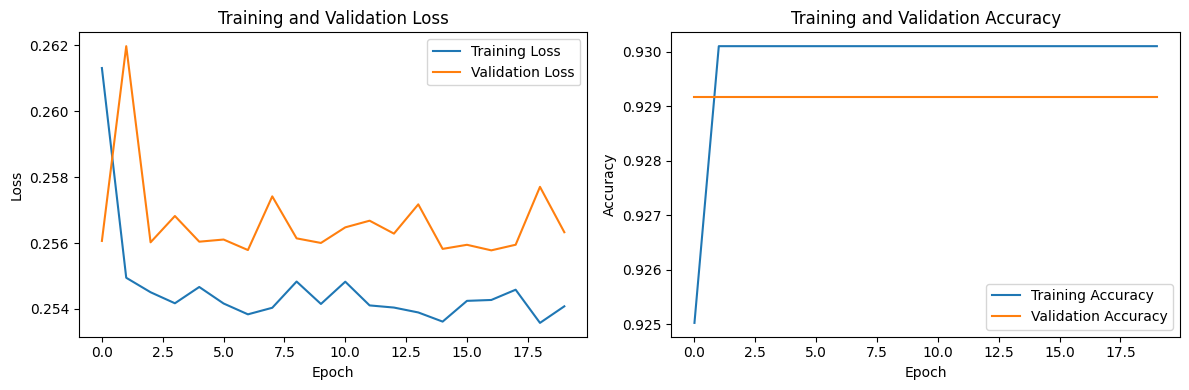

In [21]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Enhancement

In [22]:
def calculate_f1_score(model, X, y_true):
    y_pred_proba = model.predict(X)
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()
    
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    
    #print(classification_report(y_true, y_pred))
    
    return macro_f1

In [27]:
def hyperparameter_tuning(X_train, y_train, X_val, y_val, vocab_size, embedding_dim, max_len, embedding_matrix=None):
    results = []
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    hyperparams = [
        ('rnn', 1, 64, True, 32, 0.2, 0.001, 'adam'),
        ('lstm', 1, 64, False, 32, 0.2, 0.001, 'adam'),
        ('gru', 1, 64, False, 32, 0.2, 0.001, 'adam'),
        ('lstm', 2, 64, False, 32, 0.2, 0.001, 'adam'),
        ('lstm', 1, 128, False, 32, 0.2, 0.001, 'adam'),
        ('lstm', 1, 64, True, 32, 0.2, 0.001, 'adam'),
        ('lstm', 1, 64, False, 64, 0.2, 0.001, 'adam'),
        ('lstm', 1, 64, False, 32, 0.3, 0.001, 'adam'),
        ('lstm', 1, 64, True, 32, 0.2, 0.01, 'adam'),
        ('lstm', 1, 64, False, 32, 0.2, 0.001, 'rmsprop'),
        ('gru', 2, 128, True, 64, 0.3, 0.001, 'adam'),
    ]
    
    for rnn_type, num_layers, num_units, bidirectional, batch_size, dropout, learning_rate, optimizer_name in hyperparams:
        print(f"\nTraining model with: RNN={rnn_type}, Layers={num_layers}, Units={num_units}, "
              f"Bidirectional={bidirectional}, Batch={batch_size}, Dropout={dropout}, "
              f"LR={learning_rate}, Optimizer={optimizer_name}")
        
        if optimizer_name == 'adam':
            optimizer = Adam(learning_rate=learning_rate)
        elif optimizer_name == 'rmsprop':
            optimizer = RMSprop(learning_rate=learning_rate)
        elif optimizer_name == 'sgd':
            optimizer = SGD(learning_rate=learning_rate)
        
        model = create_rnn_model(vocab_size=vocab_size, embedding_dim=embedding_dim, max_len=max_len, embedding_matrix=embedding_matrix, rnn_type=rnn_type,
            num_layers=num_layers, num_units=num_units, bidirectional=bidirectional, dropout=dropout, optimizer=optimizer_name)
        
        model.compile(optimizer=optimizer, loss='binary_crossentropy',metrics=['accuracy'])
        
        history, val_metrics = train_evaluate_model(model=model, X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, batch_size=batch_size,
            epochs=10, callbacks=[early_stopping])
        
        val_f1 = calculate_f1_score(model, X_val, y_val)
        
        results.append({
            'rnn_type': rnn_type,
            'num_layers': num_layers,
            'num_units': num_units,
            'bidirectional': bidirectional,
            'batch_size': batch_size,
            'dropout': dropout,
            'learning_rate': learning_rate,
            'optimizer': optimizer_name,
            'val_loss': val_metrics[0],
            'val_accuracy': val_metrics[1],
            'val_f1_macro': val_f1
        })
    
    return results

### Running Experiments

In [28]:
pipeline = Pipeline([
    ("clean", textCleaner(text_column="tweet")),
    ("vectorize", Vectorizer(method="SEQUENCE_GLOVE", text_column="tweet", num_words=10000, max_len=100)),
])

X_train_clean = pipeline.fit_transform(train)
y_train = train["label"].values

X_val_clean = pipeline.transform(val)
y_val = val["label"].values

X_test_clean = pipeline.transform(test)
y_test = test["label"].values

vectorizer = pipeline.named_steps["vectorize"]
embedding_matrix = vectorizer.embedding_matrix_
vocab_size = min(len(vectorizer.tokenizer_.word_index) + 1, vectorizer.num_words)
embedding_dim = vectorizer.vector_size
max_len = vectorizer.max_len

print("Vocabulary size:", vocab_size)
print("Embedding dimension:", embedding_dim)
print("Maximum sequence length:", max_len)

Vocabulary size: 10000
Embedding dimension: 300
Maximum sequence length: 100


#### Tune hyperparamters

In [29]:
results = hyperparameter_tuning(X_train_clean, y_train, X_val_clean, y_val, vocab_size, embedding_dim, max_len, embedding_matrix)


Training model with: RNN=rnn, Layers=1, Units=64, Bidirectional=True, Batch=32, Dropout=0.2, LR=0.001, Optimizer=adam
Epoch 1/10
690/690 [==============================] - 321s 458ms/step - loss: 0.2088 - accuracy: 0.9329 - val_loss: 0.1852 - val_accuracy: 0.9393
Epoch 2/10
690/690 [==============================] - 228s 330ms/step - loss: 0.1673 - accuracy: 0.9407 - val_loss: 0.1639 - val_accuracy: 0.9427
Epoch 3/10
690/690 [==============================] - 226s 328ms/step - loss: 0.1537 - accuracy: 0.9461 - val_loss: 0.1627 - val_accuracy: 0.9412
Epoch 4/10
690/690 [==============================] - 223s 324ms/step - loss: 0.1479 - accuracy: 0.9480 - val_loss: 0.1530 - val_accuracy: 0.9444
Epoch 5/10
690/690 [==============================] - 223s 323ms/step - loss: 0.1408 - accuracy: 0.9494 - val_loss: 0.1545 - val_accuracy: 0.9463
Epoch 6/10
690/690 [==============================] - 226s 328ms/step - loss: 0.1336 - accuracy: 0.9501 - val_loss: 0.1501 - val_accuracy: 0.9459
Epoch

model 0: acc = 0.9461, macro f1 = 0.7429
model 1: acc = 0.9292, macro f1 = 0.4816
model 2: acc = 0.9292, macro f1 = 0.4816
model 3: acc = 0.9292, macro f1 = 0.4816
model 4: acc = 0.9292, macro f1 = 0.4816
model 5: acc = 0.9564, macro f1 = 0.7984
model 6: acc = 0.9292, macro f1 = 0.4816
model 7: acc = 0.9292, macro f1 = 0.4816
model 8: acc = 0.9520, macro f1 = 0.7945
model 9: acc = 0.9292, macro f1 = 0.4816
model 10: acc = 0.9548, macro f1 = 0.8022


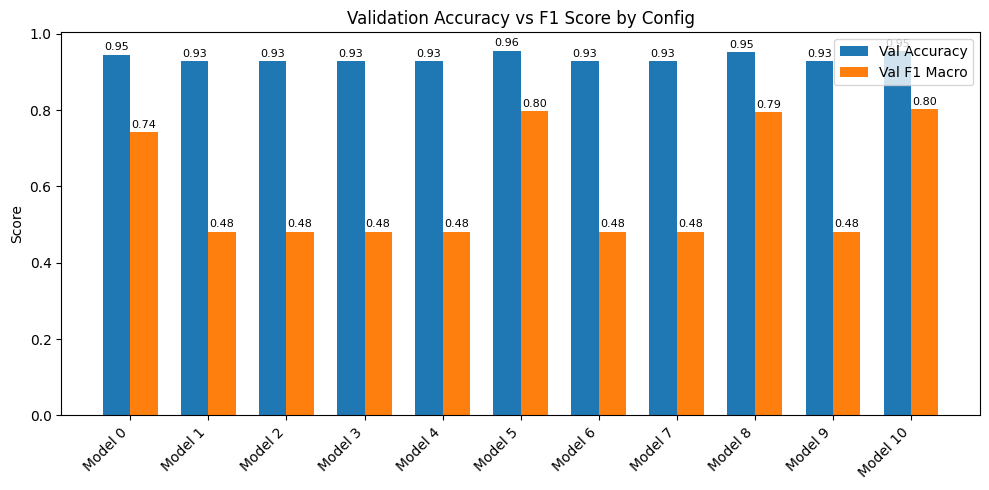

In [41]:
for i,result in enumerate(results):
    print(f"model {i}: acc = {result['val_accuracy']:.4f}, macro f1 = {result['val_f1_macro']:.4f}")

results_df = pd.DataFrame(results)

results_df['config_label'] = [f"Model {i}" for i in range(len(results_df))]


x = np.arange(len(results_df))
width = 0.35
fig, ax = plt.subplots(figsize=(10, 5))
bars1 = ax.bar(x - width/2, results_df['val_accuracy'], width, label='Val Accuracy')
bars2 = ax.bar(x + width/2, results_df['val_f1_macro'], width, label='Val F1 Macro')
ax.set_ylabel('Score')
ax.set_title('Validation Accuracy vs F1 Score by Config')
ax.set_xticks(x)
ax.set_xticklabels(results_df['config_label'], rotation=45, ha='right')
ax.legend()

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', fontsize=8)

plt.tight_layout()
plt.show()


- Models, 0, 5, 8, 10 get best amcro f1 scores (when bidirectional is True)
- We will contiune to tune model 5

In [31]:
best_config = results[5]
best_config

{'rnn_type': 'lstm',
 'num_layers': 1,
 'num_units': 64,
 'bidirectional': True,
 'batch_size': 32,
 'dropout': 0.2,
 'learning_rate': 0.001,
 'optimizer': 'adam',
 'val_loss': 0.12433173507452011,
 'val_accuracy': 0.9564481973648071,
 'val_f1_macro': 0.7984134248160154}

#### Tune Architectures

we will use the best hyperparamters and test it on different architectures (RNN, LSTM, GRU)

In [58]:
architectures = ['rnn', 'lstm', 'gru']
arch_results = []

for arch in architectures:
    print(f"\nTraining {arch.upper()} model...")
    final_model = create_rnn_model(vocab_size=vocab_size, embedding_dim=embedding_dim, max_len=max_len, embedding_matrix=embedding_matrix, rnn_type=arch, num_layers=best_config['num_layers'],
        num_units=best_config['num_units'], bidirectional=best_config['bidirectional'],dropout=best_config['dropout'])
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=5,restore_best_weights=True)
    final_model.compile(optimizer=best_config['optimizer'], loss='binary_crossentropy', metrics=['accuracy'])

    history, val_metrics = train_evaluate_model(final_model, X_train_clean, y_train, X_val_clean, y_val, epochs=10, batch_size=best_config['batch_size'])
    
    val_f1 = calculate_f1_score(final_model, X_val_clean, y_val)
    
    arch_results.append({
        'architecture': arch,
        'val_loss': val_metrics[0],
        'val_accuracy': val_metrics[1],
        'val_f1_macro': val_f1
    })


Training RNN model...
Epoch 1/10
690/690 [==============================] - 219s 316ms/step - loss: 0.1947 - accuracy: 0.9350 - val_loss: 0.1690 - val_accuracy: 0.9381
Epoch 2/10
690/690 [==============================] - 235s 340ms/step - loss: 0.1617 - accuracy: 0.9418 - val_loss: 0.1648 - val_accuracy: 0.9427
Epoch 3/10
690/690 [==============================] - 243s 353ms/step - loss: 0.1491 - accuracy: 0.9451 - val_loss: 0.1871 - val_accuracy: 0.9431
Epoch 4/10
690/690 [==============================] - 233s 338ms/step - loss: 0.1410 - accuracy: 0.9508 - val_loss: 0.1699 - val_accuracy: 0.9446
Epoch 5/10
690/690 [==============================] - 229s 332ms/step - loss: 0.1539 - accuracy: 0.9467 - val_loss: 0.1707 - val_accuracy: 0.9448
Epoch 6/10
690/690 [==============================] - 231s 335ms/step - loss: 0.1353 - accuracy: 0.9511 - val_loss: 0.1611 - val_accuracy: 0.9471
Epoch 7/10
690/690 [==============================] - 231s 334ms/step - loss: 0.1215 - accuracy: 0.95

model 0: acc = 0.9484, macro f1 = 0.7472
model 1: acc = 0.9575, macro f1 = 0.8063
model 2: acc = 0.9554, macro f1 = 0.8148


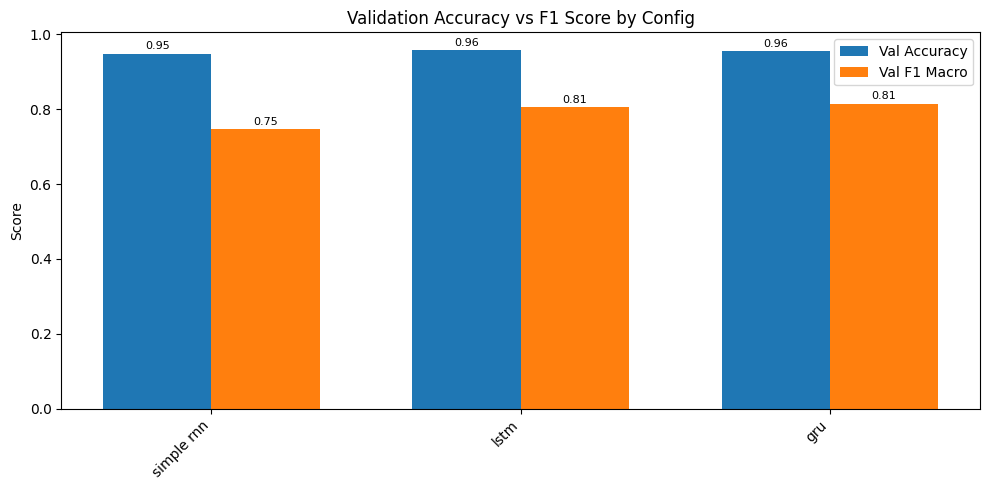

In [59]:
for i,result in enumerate(arch_results):
    print(f"model {i}: acc = {result['val_accuracy']:.4f}, macro f1 = {result['val_f1_macro']:.4f}")

arc_results_df = pd.DataFrame(arch_results)

arc_results_df['config_label'] = ["simple rnn", 'lstm', "gru"]


x = np.arange(len(arc_results_df))
width = 0.35
fig, ax = plt.subplots(figsize=(10, 5))
bars1 = ax.bar(x - width/2, arc_results_df['val_accuracy'], width, label='Val Accuracy')
bars2 = ax.bar(x + width/2, arc_results_df['val_f1_macro'], width, label='Val F1 Macro')
ax.set_ylabel('Score')
ax.set_title('Validation Accuracy vs F1 Score by Config')
ax.set_xticks(x)
ax.set_xticklabels(arc_results_df['config_label'], rotation=45, ha='right')
ax.legend()

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', fontsize=8)

plt.tight_layout()
plt.show()


#### Tune Embeddings

try best model we got till now with different embddedings

In [44]:
pipeline = Pipeline([
    ("clean", textCleaner(text_column="tweet")),
    ("vectorize", Vectorizer(method="SEQUENCE_GLOVE", text_column="tweet", num_words=10000, max_len=100)),
])

X_train_clean = pipeline.fit_transform(train)
y_train = train["label"].values

X_val_clean = pipeline.transform(val)
y_val = val["label"].values

X_test_clean = pipeline.transform(test)
y_test = test["label"].values

vectorizer = pipeline.named_steps["vectorize"]
tokenizer = vectorizer.tokenizer_
vocab_size = min(len(tokenizer.word_index) + 1, vectorizer.num_words)
embedding_dim = vectorizer.vector_size
max_len = vectorizer.max_len

print("Vocabulary size:", vocab_size)
print("Embedding dimension:", embedding_dim)
print("Maximum sequence length:", max_len)

Vocabulary size: 10000
Embedding dimension: 300
Maximum sequence length: 100


In [55]:
def build_embedding_matrix(word_index, embedding_dim, embeddings, num_words=10000):
    embedding_matrix = np.zeros((num_words, embedding_dim))
    for word, i in word_index.items():
        if i >= num_words:
            continue
        if word in embeddings:
            embedding_matrix[i] = embeddings[word]
    return embedding_matrix


def compare_embeddings(X_train, y_train, X_val, y_val, vocab_size, max_len, tokenizer, model_config):
    results = []

    embedding_configs = [
        ('random', 200),
        ('random', 300),
        ('glove', 100),
        ('glove', 300),
        ('word2vec', 300),
        ('fasttext', 300),
    ]

    for embedding_type, embedding_dim in embedding_configs:
        print(f"\nTraining with embedding: Type={embedding_type}, Dim={embedding_dim}")

        embedding_matrix = None

        if embedding_type == 'glove':
            glove_name = f"glove-wiki-gigaword-{embedding_dim}"
            embeddings = api.load(glove_name)
            embedding_matrix = build_embedding_matrix(tokenizer.word_index, embedding_dim, embeddings, num_words=vocab_size)

        elif embedding_type == 'word2vec':
            embeddings = api.load("word2vec-google-news-300")
            embedding_matrix = build_embedding_matrix(tokenizer.word_index, embedding_dim, embeddings,  num_words=vocab_size)

        elif embedding_type == 'fasttext':
            embeddings = api.load("fasttext-wiki-news-subwords-300")
            embedding_matrix = build_embedding_matrix(tokenizer.word_index, embedding_dim, embeddings,  num_words=vocab_size)

        model = create_rnn_model(
            vocab_size=vocab_size,
            embedding_dim=embedding_dim,
            max_len=max_len,
            embedding_matrix=embedding_matrix,
            rnn_type=model_config['rnn_type'],
            num_layers=model_config['num_layers'],
            num_units=model_config['num_units'],
            bidirectional=model_config['bidirectional'],
            dropout=model_config['dropout'],
            trainable_embedding=(embedding_type == 'random')
        )

        history, val_metrics = train_evaluate_model(
            model=model,
            X_train=X_train,
            y_train=y_train,
            X_val=X_val,
            y_val=y_val,
            batch_size=model_config['batch_size'],
            epochs=10
        )

        val_f1 = calculate_f1_score(model, X_val, y_val)

        results.append({
            'embedding_type': embedding_type,
            'embedding_dim': embedding_dim,
            'val_loss': val_metrics[0],
            'val_accuracy': val_metrics[1],
            'val_f1_macro': val_f1
        })

    return results

In [56]:
embedded_results = compare_embeddings(X_train_clean, y_train, X_val_clean, y_val, vocab_size, max_len, tokenizer, best_config)


Training with embedding: Type=random, Dim=200
Epoch 1/10
690/690 [==============================] - 18s 22ms/step - loss: 0.1671 - accuracy: 0.9466 - val_loss: 0.1225 - val_accuracy: 0.9579
Epoch 2/10
690/690 [==============================] - 13s 19ms/step - loss: 0.0794 - accuracy: 0.9726 - val_loss: 0.1215 - val_accuracy: 0.9571
Epoch 3/10
690/690 [==============================] - 13s 19ms/step - loss: 0.0461 - accuracy: 0.9849 - val_loss: 0.1450 - val_accuracy: 0.9573
Epoch 4/10
690/690 [==============================] - 14s 20ms/step - loss: 0.0247 - accuracy: 0.9920 - val_loss: 0.1849 - val_accuracy: 0.9552
Epoch 5/10
690/690 [==============================] - 14s 20ms/step - loss: 0.0158 - accuracy: 0.9949 - val_loss: 0.2030 - val_accuracy: 0.9562
Epoch 6/10
690/690 [==============================] - 13s 19ms/step - loss: 0.0102 - accuracy: 0.9965 - val_loss: 0.2330 - val_accuracy: 0.9514
Epoch 7/10
690/690 [==============================] - 13s 20ms/step - loss: 0.0066 - accu

model 0: acc = 0.9476, macro f1 = 0.8008
model 1: acc = 0.9543, macro f1 = 0.8147
model 2: acc = 0.9569, macro f1 = 0.8090
model 3: acc = 0.9545, macro f1 = 0.8003
model 4: acc = 0.9543, macro f1 = 0.7737
model 5: acc = 0.9531, macro f1 = 0.7886


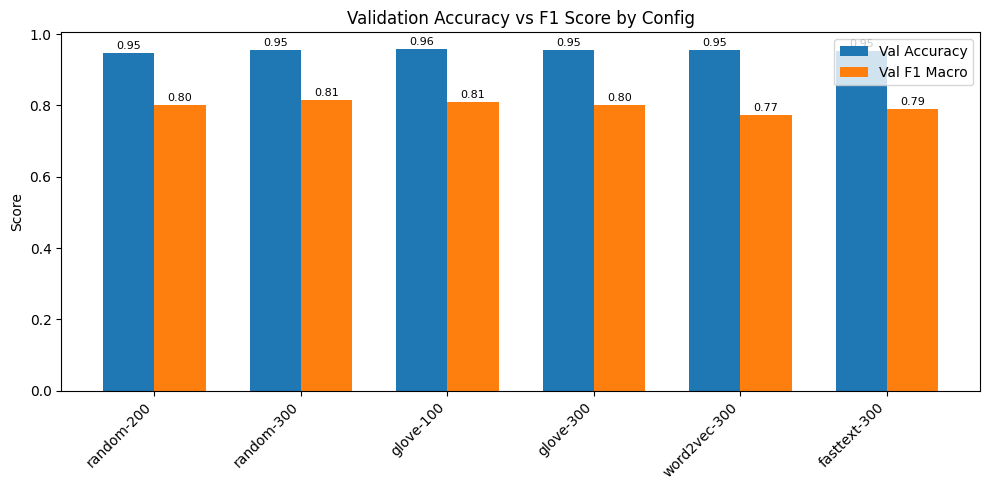

In [57]:
for i,result in enumerate(embedded_results):
    print(f"model {i}: acc = {result['val_accuracy']:.4f}, macro f1 = {result['val_f1_macro']:.4f}")

embedded_results_df = pd.DataFrame(embedded_results)

embedded_results_df['config_label'] = [
    'random-200',
    'random-300',
    'glove-100',
    'glove-300',
    'word2vec-300',
    'fasttext-300'
]


x = np.arange(len(embedded_results_df))
width = 0.35
fig, ax = plt.subplots(figsize=(10, 5))
bars1 = ax.bar(x - width/2, embedded_results_df['val_accuracy'], width, label='Val Accuracy')
bars2 = ax.bar(x + width/2, embedded_results_df['val_f1_macro'], width, label='Val F1 Macro')
ax.set_ylabel('Score')
ax.set_title('Validation Accuracy vs F1 Score by Config')
ax.set_xticks(x)
ax.set_xticklabels(embedded_results_df['config_label'], rotation=45, ha='right')
ax.legend()

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', fontsize=8)

plt.tight_layout()
plt.show()


### Results & Conclusion

- Models working in single direction can't get over the base line accuracy (93%). Only Bidirectional models works well
- LSTM and GRU peroforms better than Simple RNN
- LSTM and GRU are faster in training than Simple RNN and that happens because they have better GPU optimization
- Best Model: Emedding: <span style="color:skyblue">GLOVE-100</span>, RNN_TYPE: <span style="color:skyblue">LSTM</span>,